In [2]:
import pretty_midi
import librosa
from matplotlib import pyplot as plt
import os
import miditok

In [3]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

/tmp/ipykernel_7878/4272272150.py:2: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


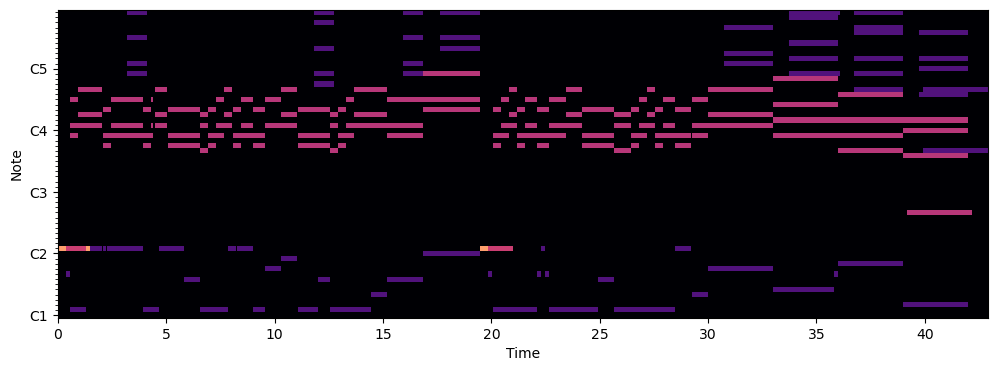

In [4]:
example_track_path = '../data/external/Jazz Midi/5To10.mid'
example_track = pretty_midi.PrettyMIDI(example_track_path)

plt.figure(figsize=(12, 4))
plot_piano_roll(example_track, 24, 84)

In [ ]:
!wget -O ../models/model.pt http://vault.sfu.ca/index.php/s/Ff2j19IrKS5R969/download

In [5]:
db_path = '../data/external'
db_folders = [x[0] for x in os.walk(db_path)]
midi_file_paths = []
for folder_path in db_folders:
    midi_file_paths += [ os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mid')]
print(f'Number of tracks: {len(midi_file_paths)}')

Number of tracks: 934


In [6]:
midis = []
for file_path in midi_file_paths:
    try:
        midis.append(pretty_midi.PrettyMIDI(file_path))
    except Exception as ex:
        # print(f'Exception occured: {type(ex).__name__}')
        continue

/home/julia/anaconda3/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [7]:
print(f'Number of properly loaded files: {len(midis)}')

Number of properly loaded files: 915


In [8]:
track_lengths = [ midi.get_end_time() for midi in midis ]
max_tl = max(track_lengths)
track_lengths_without_max = [tl for tl in track_lengths if tl < max_tl]
# plt.hist(track_lengths_without_max, bins=20, edgecolor='black')

In [9]:
sum(track_lengths)

211241.65849309575

(array([ 99.,  18.,  88.,  66., 224.,  71., 121.,  44.,  62.,  35.,  46.,
         11.,  11.,   4.,   7.,   1.,   3.,   2.,   1.,   1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ,
        17.5, 19. , 20.5, 22. , 23.5, 25. , 26.5, 28. , 29.5, 31. ]),
 <BarContainer object of 20 artists>)

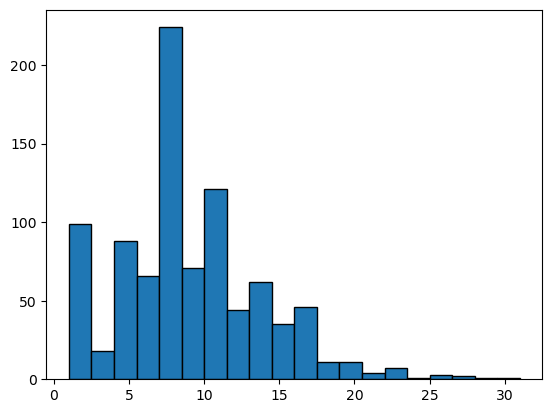

In [10]:
instrument_number = [ len(midi.instruments) for midi in midis ]
plt.hist(instrument_number, bins=20, edgecolor='black')

In [11]:
# divide into 4 bar chunks

# mmm tokenize it

In [2]:
import miditok
import torch

config = miditok.TokenizerConfig()
config.additional_params = { "base_tokenizer" : 'REMI' }

tokenizer = miditok.MMM(config)
example_track_path = '../data/external/Jazz Midi/5To10.mid'
encoded = tokenizer.encode(example_track_path)

model_path = '../models/model.pt'
model = torch.load(model_path)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = torch.tensor([encoded], dtype=torch.long).to(device)


/home/julia/anaconda3/lib/python3.10/site-packages/torch/serialization.py:707: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [10]:
print(model.code)

def forward(self,
    input_ids: Tensor,
    argument_2: Tuple[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor]]) -> Tuple[Tensor, Tuple[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor], Tuple[Tensor, Tensor]]]:
  lm_head = self.lm_head
  transformer = self.transformer
  _0, _1, _2, _3, _4, _5, = argument_2
  _6, past_value, = _0
  _7, past_value0, = _1
  _8, past_value1, = _2
  _9, past_value2, = _3
  _10, past_value3, = _4
  _11, past_value4, = _5
  _12 = (transformer).forward(input_ids, _6, past_value, _7, past_value0, _8, past_value1, _9, past_value2, _10, past_value3, _11, past_value4, )
  _13, _14, _15, _16, _17, _18, _19, _20, _21, _22, _23, _24, _25, = _12
  _26 = (lm_head).forward(_13, )
  _27 = ((_14, _15), (_16, _17), (_18, _19), (_20, _21), (_22, _23), (_24, _25))
  return (_26, _27)



In [18]:
input_ids = input_ids[:, :1024]

In [25]:
batch_size = input_ids.size(0)
num_heads = 8           # Set based on model's actual configuration
hidden_dim = 512         # This is usually hidden_size / num_heads
sequence_length = input_ids.size(1)

argument_2 = tuple(
    (
        torch.zeros((batch_size, num_heads, sequence_length, hidden_dim // num_heads), dtype=torch.float32).to(device),  # past_key
        torch.zeros((batch_size, num_heads, sequence_length, hidden_dim // num_heads), dtype=torch.float32).to(device)   # past_value
    )
    for _ in range(6)  # Six layers, assuming GPT-2 small
)

In [42]:
# Forward pass with all required inputs
with torch.no_grad():
    output = model(input_ids, argument_2)

In [43]:
len(output)

2

In [47]:
piece = output[0]
len(piece[0])

1024

In [51]:
tokenizer.decode(piece)

ValueError: The input sequence does not have the expected dimension (3 instead of 1).

In [35]:
tokens = logits.argmax(dim=-1).squeeze().tolist()  # Convert logits to a list of token IDs

# Convert tokens to TokSequence
token_sequence = miditok.TokSequence(ids=tokens)

# Decode tokens to MIDI Score and save
midi_obj = tokenizer.decode([token_sequence])
midi_obj[0].dump("generated_output.mid")  # Save as MIDI file

KeyError: 570